In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

/Users/jinghan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/jinghan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


#### Import Indices

In [2]:
indices = ['^GSPC','^DJI','^IXIC','^NYA','^XAX','^BUK100P','^RUT','^VIX','^FTSE','^GDAXI','^FCHI',
            '^FCHI', '^STOXX50E','^N100','^BFX','IMOEX.ME','^N225', '^HSI', '000001.SS','399001.SZ','^STI',
            '^AXJO','^AORD','^BSESN','^JKSE','^KLSE','^NZ50','^TWII','^GSPTSE','^BVSP','^MXX','^IPSA','^MERV',
            '^TA125.TA','^CASE30','^JN0U.JO']

In [3]:
indices = ['SPY','VOO','DIA','QQQ','IWM','VXZ','VIXM','SVOL','ISF.L','EWG','EWQ','VGK','FEZ',
            'BEL.BR','ERUS','1329.T','9115.HK','510210.SS','159903.SZ','ES3.SI','IOZ.AX','VAS'
            ,'2836.HK','EIDO','0820EA.KL','NZG.NZ','EWY','EWT','XIC.TO','EWZ','EWW','ECH','ARGT',
            'PSG-F42.TA', 'EIS','EGPT','VTI','MDY', 'IJH','OEF','IWF','IWD','IWB','VONE',
            'PFF','IWO','IWN','ACWI','IEMG']

In [4]:
df = yf.download(indices, start='2000-01-01', end='2022-12-31', group_by='ticker')
df[indices[0]].head()

[*********************100%***********************]  49 of 49 completed

1 Failed download:
- PSG-F42.TA: No data found for this date range, symbol may be delisted


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-18 00:00:00,219.070007,219.270004,218.289993,218.500000,195.633194,86265800.0
2016-11-21 00:00:00,219.169998,220.179993,219.000000,220.149994,197.110565,72402600.0
2016-11-22 00:00:00,220.509995,220.789993,219.729996,220.580002,197.495560,67429000.0
2016-11-23 00:00:00,219.979996,220.759995,219.750000,220.699997,197.602997,56620200.0
2016-11-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
indices.pop(indices.index('PSG-F42.TA'))
df.loc[df.index < pd.to_datetime('2012-06-01'),'2836.HK'] = np.nan

In [6]:
def pair_analysis(index1, index2, plot=True):

    output = {}

    p1 = np.log(df[index1]['Adj Close']).sort_index()
    p2 = np.log(df[index2]['Adj Close']).sort_index()   

    X = pd.concat([p1, p2], axis=1).dropna()
    X.replace(to_replace=0, method='ffill')
    X.columns = ['Price 1', 'Price 2']
    y = X['Price 1']
    X = X.drop('Price 1',axis=1)

    X = sm.add_constant(X)
    result = sm.OLS(y, X).fit()
    output['const'] = [np.round(result.params[0], 4)]
    output['beta'] = [np.round(result.params[1], 4)]

    if plot:
        plt.rcParams["figure.figsize"] = (20,5)

        fig, axs = plt.subplots(1, 2)

        axs[0].plot(np.exp(X @ result.params))
        axs[0].plot(np.exp(y))
        axs[0].set_title("Scaled Price: {} vs {}".format(index2, index1))
        axs[0].legend([index2, index1])

        axs[1].plot(result.resid)
        axs[1].hlines(0,result.resid.index.min(), result.resid.index.max(), colors='r')
        axs[1].set_title("Residues: {} vs {}".format(index2, index1))

        plt.show()

    trade_period = len(result.resid)
    n_zero_cross = np.nansum(result.resid.rolling(2).apply(lambda x: 1 if np.sign(x[1]) != np.sign(x[0]) else 0))
    output['trade_period'] = [trade_period]
    output['n_zero_cross'] = [int(n_zero_cross)]

    p1 = p1.dropna() 
    p2 = p2.dropna()
    def mrk_eff_cal(p1):
        d_ret = np.log(p1 - p1.shift(1))
        m_ret = np.log(p1 - p1.shift(20))
        mrk_eff_coef = np.var(m_ret.dropna())/(20*np.var(d_ret.dropna()))
        return mrk_eff_coef
    output['mrk_eff_coef_1'] = [np.round(mrk_eff_cal(p1), 4)]
    output['mrk_eff_coef_2'] = [np.round(mrk_eff_cal(p2), 4)]

    df1 = df[index1][['Adj Close','Volume']].dropna()
    df2 = df[index2][['Adj Close','Volume']].dropna()

    df1['Dollar Volume'] = df1['Adj Close'] * df1['Volume']
    df2['Dollar Volume'] = df2['Adj Close'] * df2['Volume']

    if df1['Dollar Volume'].mean() == 0:
        output['volume_ratio'] = index1 + " 0"
    elif df2['Dollar Volume'].mean() == 0:
        output['volume_ratio'] = index2 + " 0"
    else:
        volume_ratio = df1['Dollar Volume'].mean()/df2['Dollar Volume'].mean()
        output['volume_ratio'] = [np.round(volume_ratio, 4)]

    output = pd.DataFrame.from_dict(output)
    output.index = pd.MultiIndex.from_tuples([(index1, index2)], names=["index 1", "index 2"])
    output

    return output


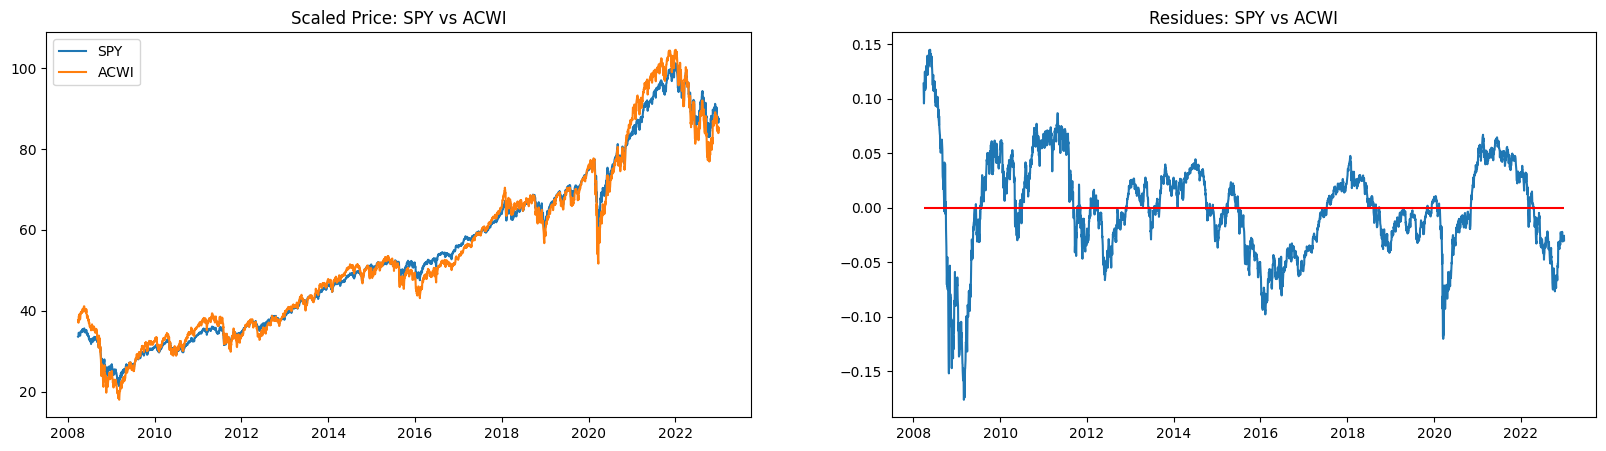

,,const,beta,trade_period,n_zero_cross,mrk_eff_coef_1,mrk_eff_coef_2,volume_ratio
index 1,index 2,,,,,,,
ACWI,SPY,0.2753,0.7056,3718,87,0.0031,0.0033,0.008


In [7]:
index1 = 'ACWI'
index2 = 'SPY'
output = pair_analysis(index1, index2, plot=True)
output

In [8]:
output_df = pd.DataFrame()
for i in tqdm(range(len(indices))):
    for j in range(i+1, len(indices)):
        try:
            output = pair_analysis(indices[i], indices[j], plot=False)
            output_df = pd.concat([output_df, output], axis=0)
        except Exception as e:
            print(indices[i], indices[j])
            print(e)
output_df

 15%|█▍        | 7/48 [01:07<05:40,  8.30s/it]

SVOL VAS
zero-size array to reduction operation maximum which has no identity


 44%|████▍     | 21/48 [03:06<03:06,  6.92s/it]

VAS NZG.NZ
zero-size array to reduction operation maximum which has no identity


100%|██████████| 48/48 [04:37<00:00,  5.77s/it]


const    beta  trade_period  n_zero_cross  mrk_eff_coef_1  \
index 1 index 2                                                               
SPY     VOO      0.0922  0.9989          3100           291          0.0033   
        DIA      0.1808  0.9966          5787            29          0.0033   
        QQQ      1.9431  0.6968          5787           105          0.0033   
        IWM      0.6609  0.9819          5686            60          0.0033   
        VXZ      4.1997  0.4970          1243            29          0.0033   
...                 ...     ...           ...           ...             ...   
IWO     ACWI    -0.3633  1.3274          3718           132          0.0028   
        IEMG    -0.9628  1.6114          2563            75          0.0028   
IWN     ACWI     0.1872  1.0729          3718           114          0.0030   
        IEMG    -0.0098  1.2275          2563            71          0.0030   
ACWI    IEMG    -1.0683  1.3732          2563            65          0.0031   

                 mrk_eff_coef_2  volume_ratio  
index 1 index 2                                
SPY     VOO              0.0032       24.8213  
        DIA              0.0032       19.8074  
        QQQ              0.0032        3.0956  
        IWM              0.0029        5.3023  
        VXZ              0.0026    22042.1839  
...                         ...           ...  
IWO     ACWI             0.0031        0.8703  
        IEMG             0.0029        0.2583  
IWN     ACWI             0.0031        0.7485  
        IEMG             0.0029        0.2222  
ACWI    IEMG             0.0029        0.2968  

[1126 rows x 7 columns]

In [9]:
output_df['percent_zero_cross'] = output_df['n_zero_cross']/output_df['trade_period']

In [10]:
output_df.sort_values('percent_zero_cross', ascending=False).head(20)

const    beta  trade_period  n_zero_cross  mrk_eff_coef_1  \
index 1 index 2                                                                 
VXZ     VIXM      -0.2143  1.0106          1243           305          0.0026   
SVOL    2836.HK    0.9463  0.6024           393            62          0.0039   
MDY     IJH        0.7056  0.9823          5686           889          0.0031   
SVOL    OEF        0.6274  0.4626           413            63          0.0039   
        IWB        0.4002  0.4878           413            63          0.0039   
        VONE       0.4796  0.4903           413            63          0.0039   
        VTI        0.5172  0.4743           413            63          0.0039   
        510210.SS  3.0860  0.5898           387            53          0.0039   
        IWF        1.2866  0.3193           413            55          0.0039   
        159903.SZ  2.9498  0.2592           387            49          0.0039   
SPY     SVOL       1.8335  1.3732           413            49          0.0033   
VOO     SVOL       1.7492  1.3731           413            49          0.0032   
SVOL    EWQ        1.7111  0.3824           413            47          0.0039   
        IWO        1.8231  0.2226           413            47          0.0039   
        NZG.NZ     2.6070  0.4750           399            45          0.0039   
        PFF        1.3400  0.4861           413            45          0.0039   
        IOZ.AX     0.7468  0.6834           403            43          0.0039   
        ECH        3.5240 -0.1459           413            43          0.0039   
        EIS        1.5171  0.3659           413            43          0.0039   
        MDY       -0.4698  0.5739           413            43          0.0039   

                   mrk_eff_coef_2  volume_ratio  percent_zero_cross  
index 1 index 2                                                      
VXZ     VIXM               0.0026        0.3540            0.245374  
SVOL    2836.HK            0.0027        0.4082            0.157761  
MDY     IJH                0.0029        3.0989            0.156349  
SVOL    OEF                0.0034        0.0271            0.152542  
        IWB                0.0031        0.0142            0.152542  
        VONE               0.0032        0.2246            0.152542  
        VTI                0.0031        0.0052            0.152542  
        510210.SS          0.0027        0.1039            0.136951  
        IWF                0.0031        0.0077            0.133172  
        159903.SZ          0.0023        0.0813            0.126615  
SPY     SVOL               0.0039    13027.9783            0.118644  
VOO     SVOL               0.0039      524.8718            0.118644  
SVOL    EWQ                0.0032        0.1048            0.113801  
        IWO                0.0028        0.0110            0.113801  
        NZG.NZ             0.0026        0.6714            0.112782  
        PFF                0.0026        0.0181            0.108959  
        IOZ.AX             0.0028        0.2492            0.106700  
        ECH                0.0026        0.1175            0.104116  
        EIS                0.0028        0.7622            0.104116  
        MDY                0.0031        0.0034            0.104116

In [11]:
output_df.sort_values('n_zero_cross', ascending=False).head(20)

,,const,beta,trade_period,n_zero_cross,mrk_eff_coef_1,mrk_eff_coef_2,volume_ratio,percent_zero_cross
index 1,index 2,,,,,,,,
MDY,IJH,0.7056,0.9823,5686,889,0.0031,0.0029,3.0989,0.156349
IWB,VONE,0.1760,1.0031,3091,308,0.0031,0.0032,15.8721,0.099644
VXZ,VIXM,-0.2143,1.0106,1243,305,0.0026,0.0026,0.3540,0.245374
DIA,IWO,0.4604,0.9428,5643,303,0.0032,0.0028,7.2179,0.053695
SPY,VOO,0.0922,0.9989,3100,291,0.0033,0.0032,24.8213,0.093871
OEF,IWF,0.5771,0.8411,5579,253,0.0034,0.0031,0.2860,0.045349
VTI,VONE,0.1189,0.9969,3091,238,0.0031,0.0032,43.0181,0.076998
VGK,IOZ.AX,-0.7337,1.4239,2972,228,0.0032,0.0028,26.2767,0.076716
EWT,IWB,-0.3481,0.7567,5667,215,0.0032,0.0031,0.8833,0.037939


SVOL: Simplify Volatility Premium ETF

SPY: SPDR S&P 500 ETF Trust

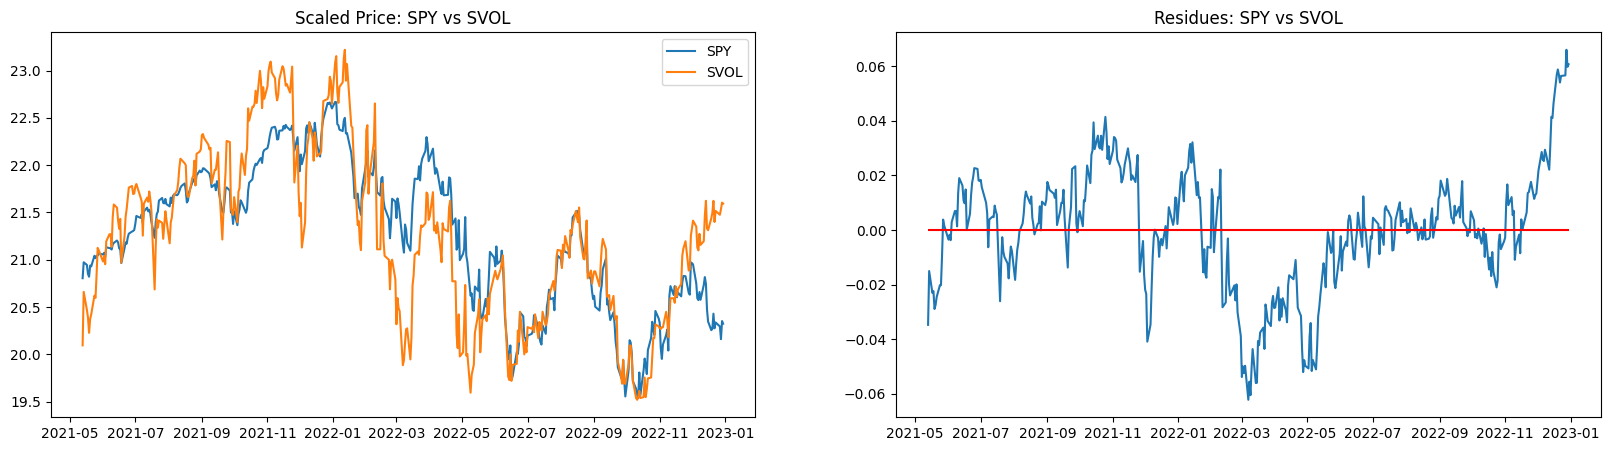

,,const,beta,trade_period,n_zero_cross,mrk_eff_coef_1,mrk_eff_coef_2,volume_ratio
index 1,index 2,,,,,,,
SVOL,SPY,-0.1372,0.5295,413,65,0.0039,0.0033,0.0001


In [12]:
pair_analysis('SVOL', 'SPY', plot=True)

DIA: SPDR Dow Jones Industrial Average ETF Trust

IWO: iShares Russell 2000 Growth ETF

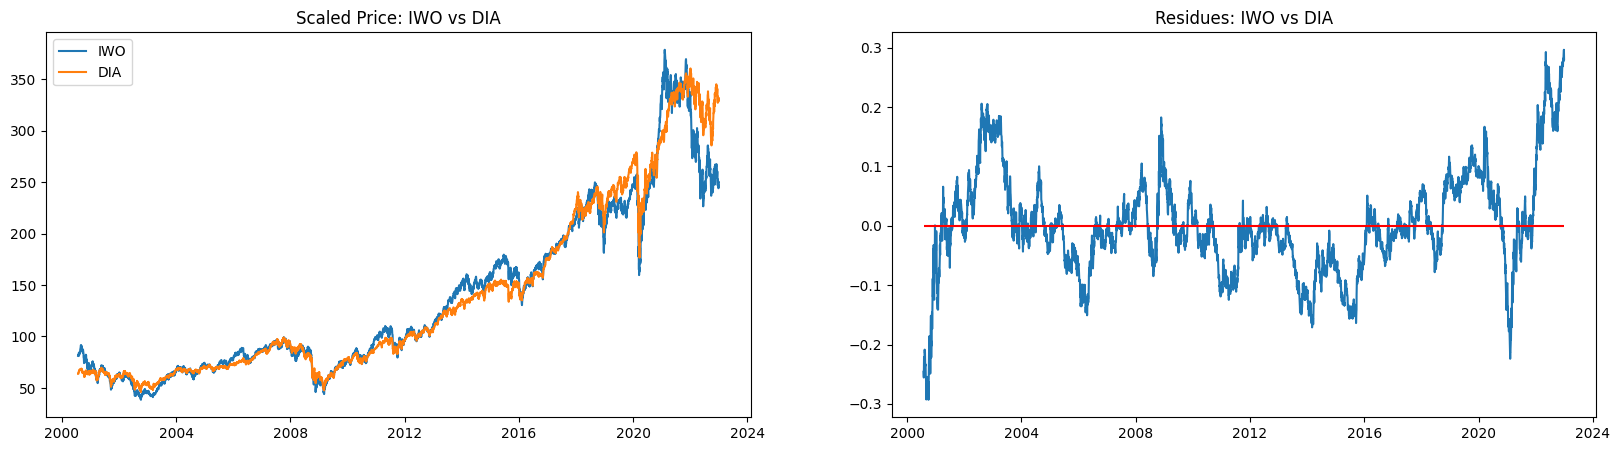

,,const,beta,trade_period,n_zero_cross,mrk_eff_coef_1,mrk_eff_coef_2,volume_ratio
index 1,index 2,,,,,,,
DIA,IWO,0.4604,0.9428,5643,303,0.0032,0.0028,7.2179


In [13]:
pair_analysis('DIA', 'IWO', plot=True)

OEF: iShares S&P 100 ETF

IWF: iShares Russell 1000 Growth ETF

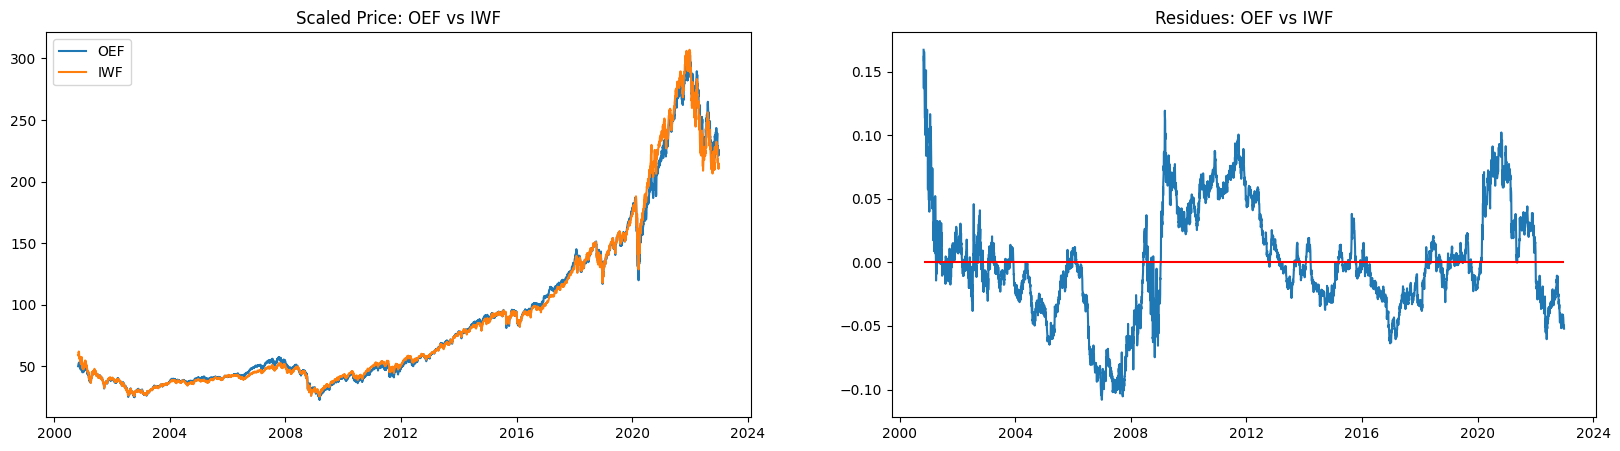

,,const,beta,trade_period,n_zero_cross,mrk_eff_coef_1,mrk_eff_coef_2,volume_ratio
index 1,index 2,,,,,,,
IWF,OEF,-0.6654,1.184,5579,223,0.0031,0.0034,3.4967


In [14]:
pair_analysis('IWF', 'OEF', plot=True)

VTI: Vanguard Total Stock Market Index Fund ETF

VONE: Vanguard Russell 1000 Index Fund ETF

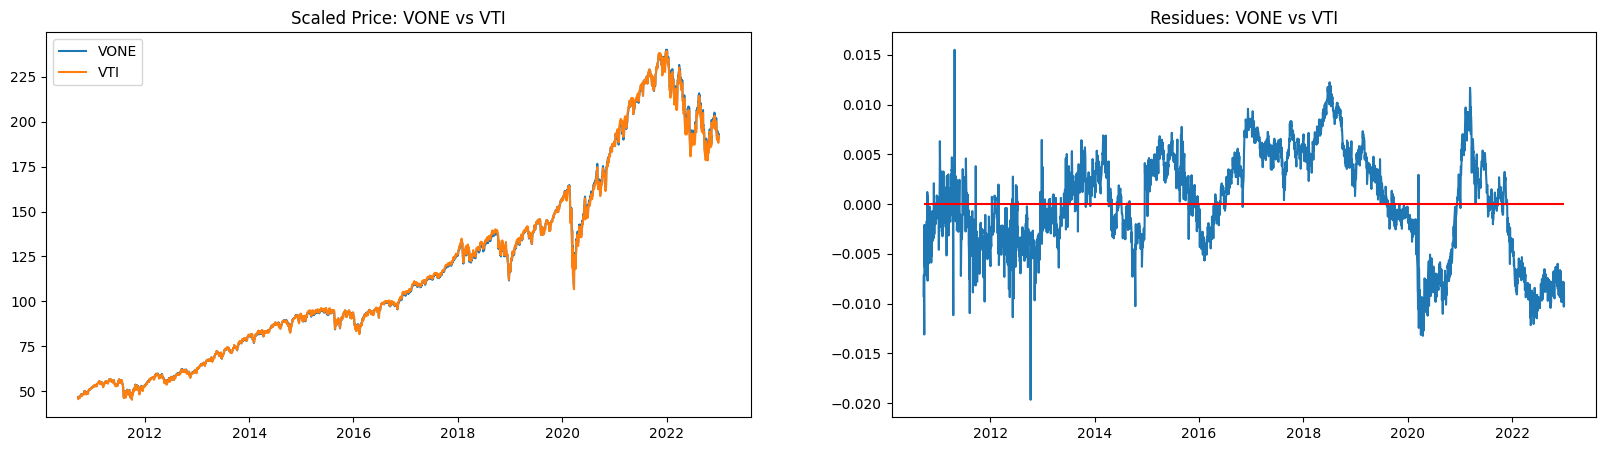

,,const,beta,trade_period,n_zero_cross,mrk_eff_coef_1,mrk_eff_coef_2,volume_ratio
index 1,index 2,,,,,,,
VTI,VONE,0.1189,0.9969,3091,238,0.0031,0.0032,43.0181


In [15]:
pair_analysis('VTI', 'VONE', plot=True)

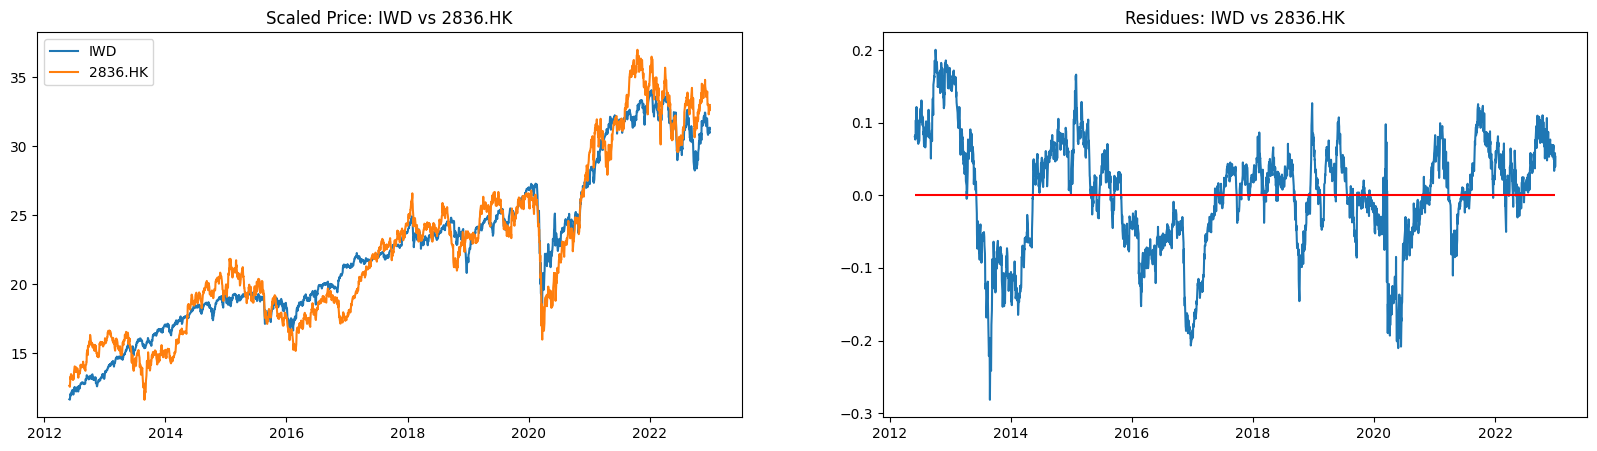

,,const,beta,trade_period,n_zero_cross,mrk_eff_coef_1,mrk_eff_coef_2,volume_ratio
index 1,index 2,,,,,,,
2836.HK,IWD,-1.009,0.8867,2547,146,0.0027,0.0031,0.0209


In [16]:
pair_analysis('2836.HK', 'IWD', plot=True)